###O'BRIEN THESIS

#Install Dependencies

 choose GPU in Runtime if not already selected

In [104]:
!rm -r /content/yolov5
%cd /content/

rm: cannot remove '/content/yolov5': No such file or directory
/content


In [105]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 16525, done.
remote: Total 16525 (delta 0), reused 0 (delta 0), pack-reused 16525
Receiving objects: 100% (16525/16525), 15.05 MiB | 14.17 MiB/s, done.
Resolving deltas: 100% (11355/11355), done.
/content/yolov5
HEAD is now at fbe67e46 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [106]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


# Download Correctly Format the dataset. Export in "yolov5" format, which is yaml.

In [107]:
#follow the link below to get your download code from from Roboflow
!pip install roboflow
from roboflow import Roboflow

In [108]:
%cd /content/yolov5
rf = Roboflow(model_format="yolov5",api_key="")
#project = rf.workspace("d4ms").project("marine-sharks-synthetic")
#dataset = project.version(1).download("yolov5")
project = rf.workspace("augie-doebling").project("sharkspotting")
dataset = project.version(1).download("yolov5")

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SharkSpotting-1 in yolov5pytorch:: 100%|██████████| 9324/9324 [00:11<00:00, 805.55it/s] 


In [109]:
%cat {dataset.location}/data.yaml

names:
- boat
- dolphin
- person
- shark
nc: 4
roboflow:
  license: CC BY 4.0
  project: sharkspotting
  url: https://universe.roboflow.com/augie-doebling/sharkspotting/dataset/1
  version: 1
  workspace: augie-doebling
test: ../test/images
train: SharkSpotting-1/train/images
val: SharkSpotting-1/valid/images


# Verifying dataset is correct
```



In [110]:
# format of dataset
%cat {dataset.location}/data.yaml

names:
- boat
- dolphin
- person
- shark
nc: 4
roboflow:
  license: CC BY 4.0
  project: sharkspotting
  url: https://universe.roboflow.com/augie-doebling/sharkspotting/dataset/1
  version: 1
  workspace: augie-doebling
test: ../test/images
train: SharkSpotting-1/train/images
val: SharkSpotting-1/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

In [111]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [112]:
#this is the model configuration we will use
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [113]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [114]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [115]:
%cd /content/yolov5/

/content/yolov5


# Train Custom YOLOv5 Detector
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [117]:
# train yolov5s on custom data for 200 epochs
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 200 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-04-05 01:41:30.746366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 01:41:30.746418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 01:41:30.748190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/SharkSpotting-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

FileNotFoundError: [Errno 2] No such file or directory: '/content/yolov5/runs/train/yolov5s_results/results.png'

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [118]:
# trained weights are saved by default in our weights folder
%ls runs

train/


In [119]:
%ls SharkSpotting-1/test/images

moreimages_100_jpg.rf.6b9050a905a630d3d81a06618992cff4.jpg
moreimages_109_jpg.rf.a16366b2e58d399d1cd793585d4ac9be.jpg
moreimages_112_jpg.rf.30f47fd108a9cc24e95bb7f3fdede6f1.jpg
moreimages_138_jpg.rf.90ad9f20df716625449a376b4e28ea07.jpg
moreimages_13_jpg.rf.edcc54211d8655263910d2ca66d5ad77.jpg
moreimages_144_jpg.rf.cbb84a5a7ce0b9d61d08aed19e97451e.jpg
moreimages_149_jpg.rf.8081f3ff8d519cf2c60bfae3a4c581e0.jpg
moreimages_152_jpg.rf.e9740003cb1ebaed9a9c7d7b76920513.jpg
moreimages_157_jpg.rf.2211251e8b6ca3f107262d12eedd12ce.jpg
moreimages_167_jpg.rf.a2175ccd1d3a3297d66ce5e42c7f4b42.jpg
moreimages_171_jpg.rf.86d090ee5596989e271896381c5b9137.jpg
moreimages_177_jpg.rf.9632fff83d53483bbf716eb4e87e15d6.jpg
moreimages_181_jpg.rf.071bea963583bf30edd07f0c38e282b5.jpg
moreimages_220_jpg.rf.b4b7954714fe5512ae106399e336ad00.jpg
moreimages_226_jpg.rf.d9183df0372fe2e7b913eb784555ce19.jpg
moreimages_236_jpg.rf.d7f64487f77480cd5c9c0d27eb2d59fb.jpg
moreimages_238_jpg.rf.d271273cb758247fb007a1ce3afef558.jp

In [120]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [121]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ./SharkSpotting-1/test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=./SharkSpotting-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-295-gac6c4383 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7254609 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/466 /content/yolov5/SharkSpotting-1/test/images/moreimages_100_jpg.rf.6b9050a905a630d3d81a06618992cff4.jpg: 256x416 1 shark, 165.0ms
image 2/466 /content/yolov5/SharkSpotting-1/test/images/moreimages_109_jpg.rf.a16366b2e58d399d1cd793585d4ac9be.jp

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


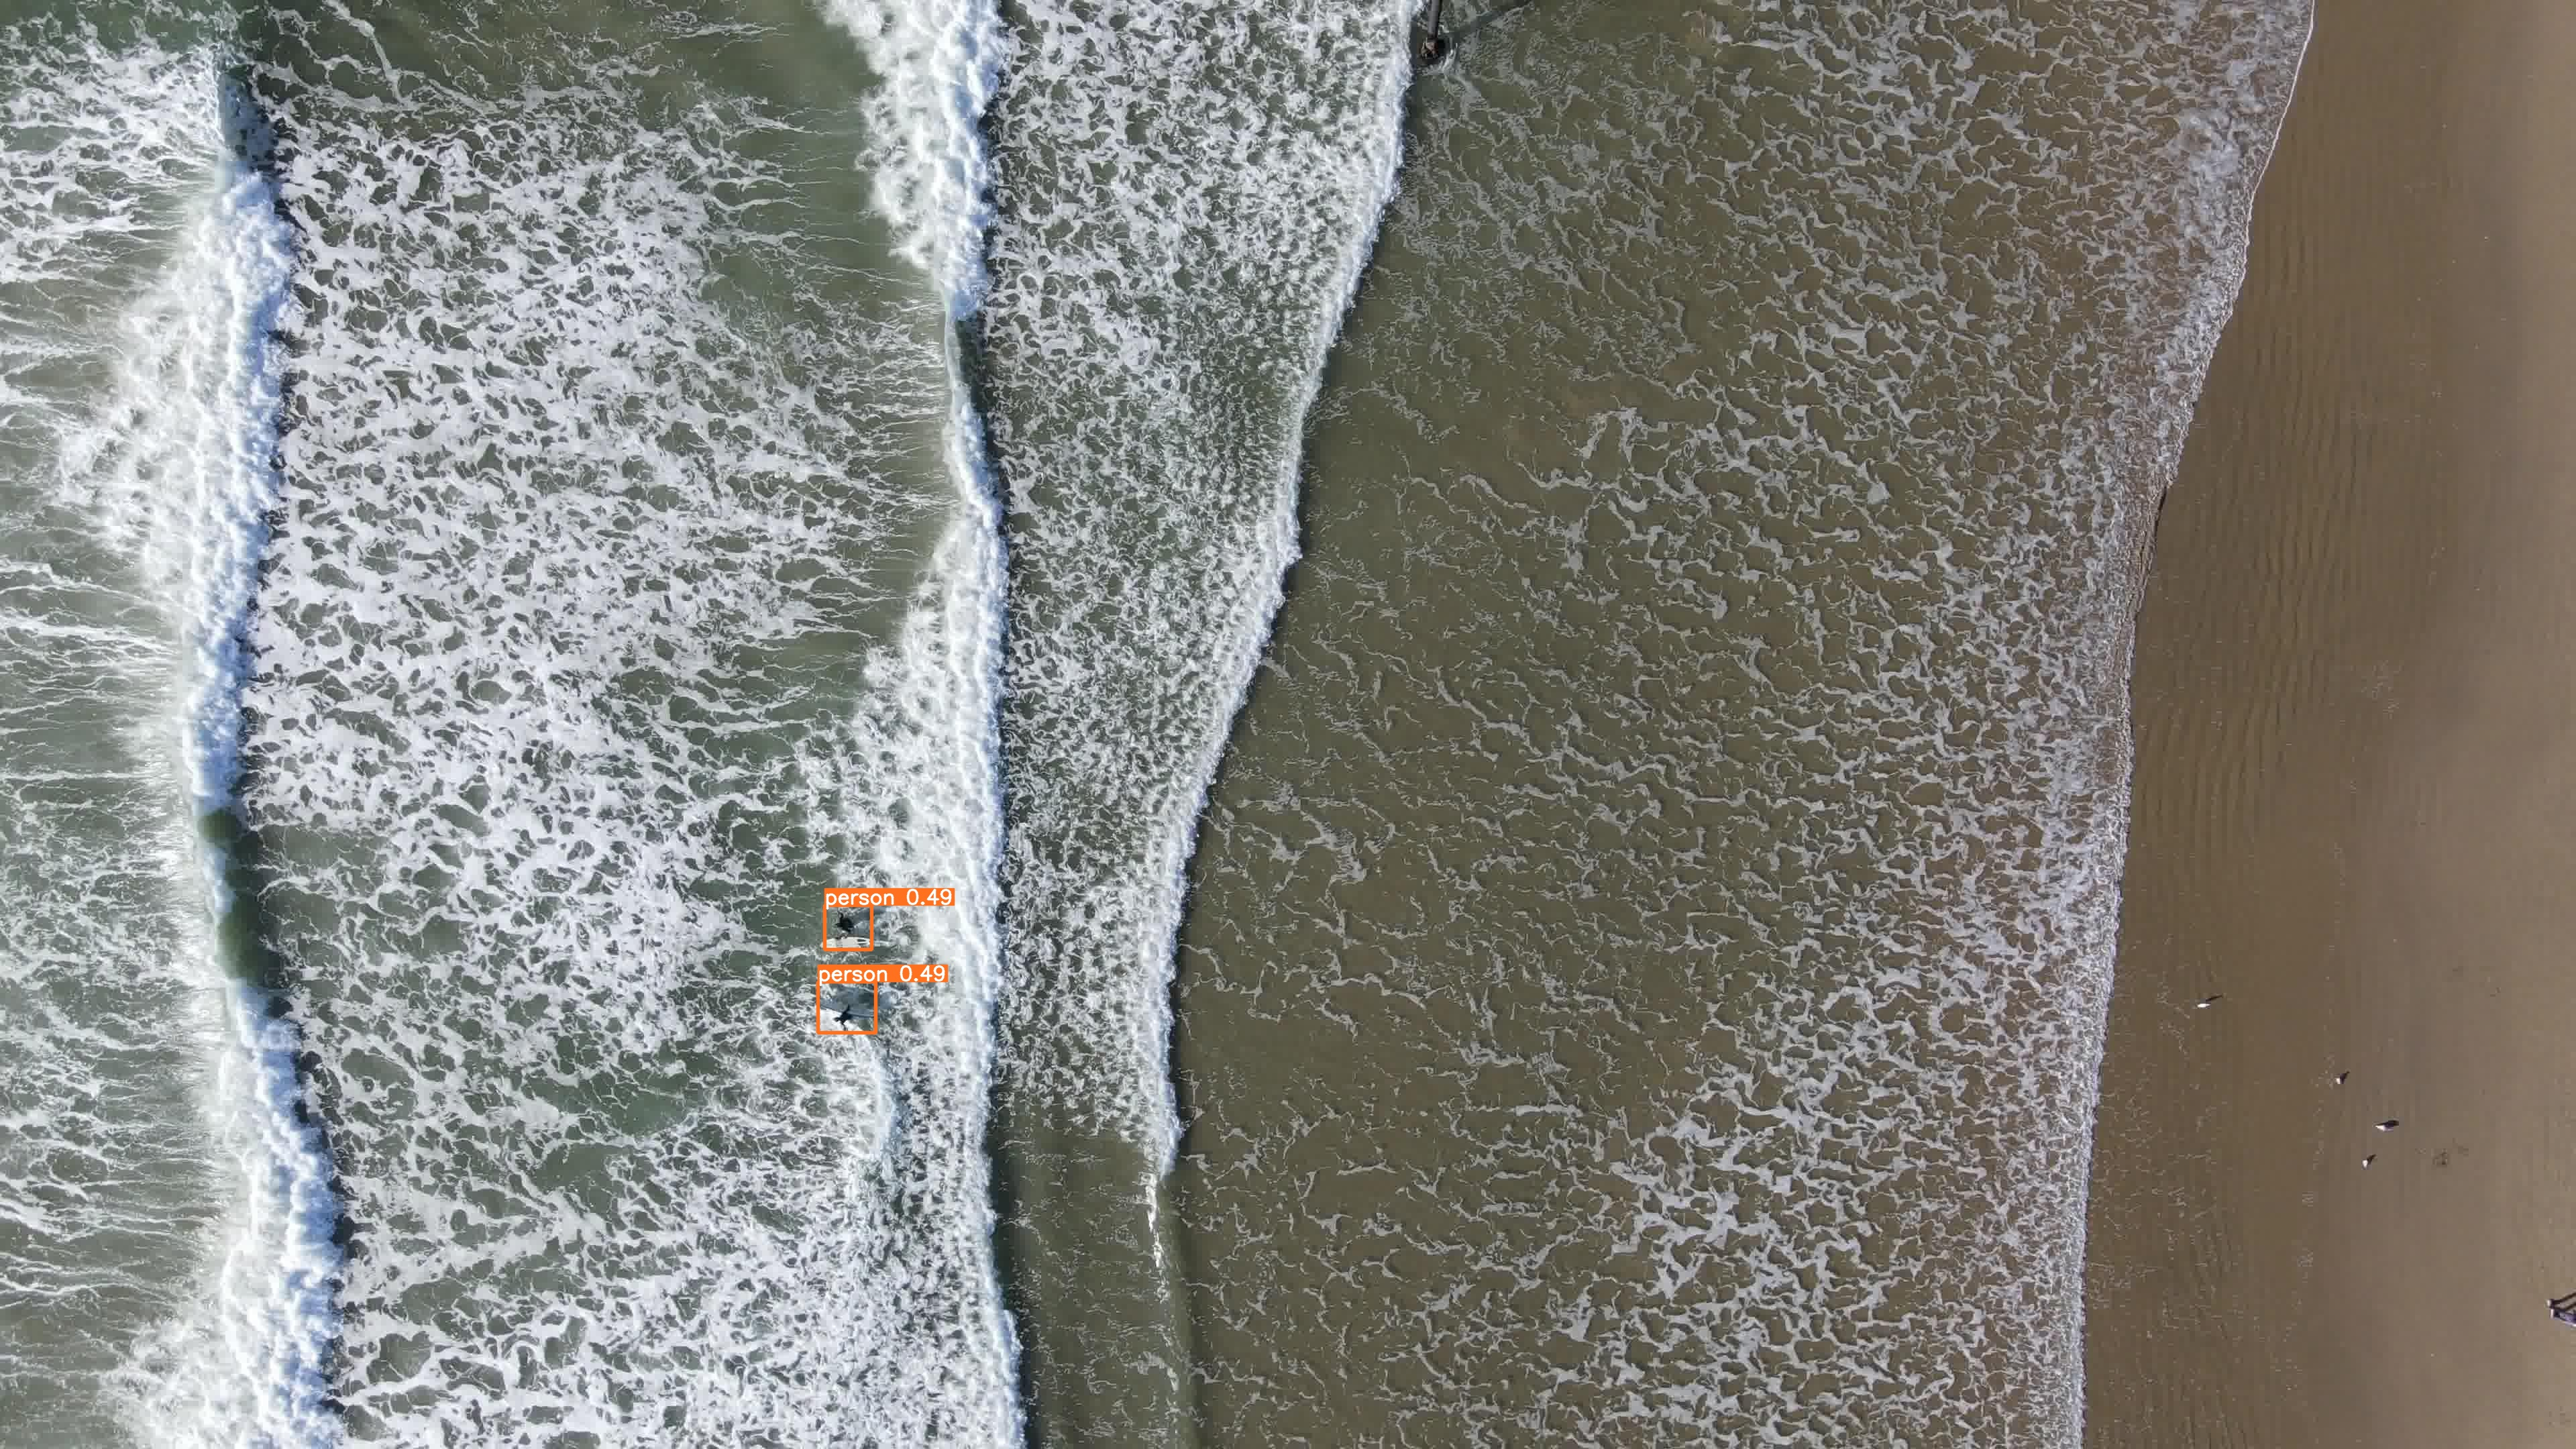

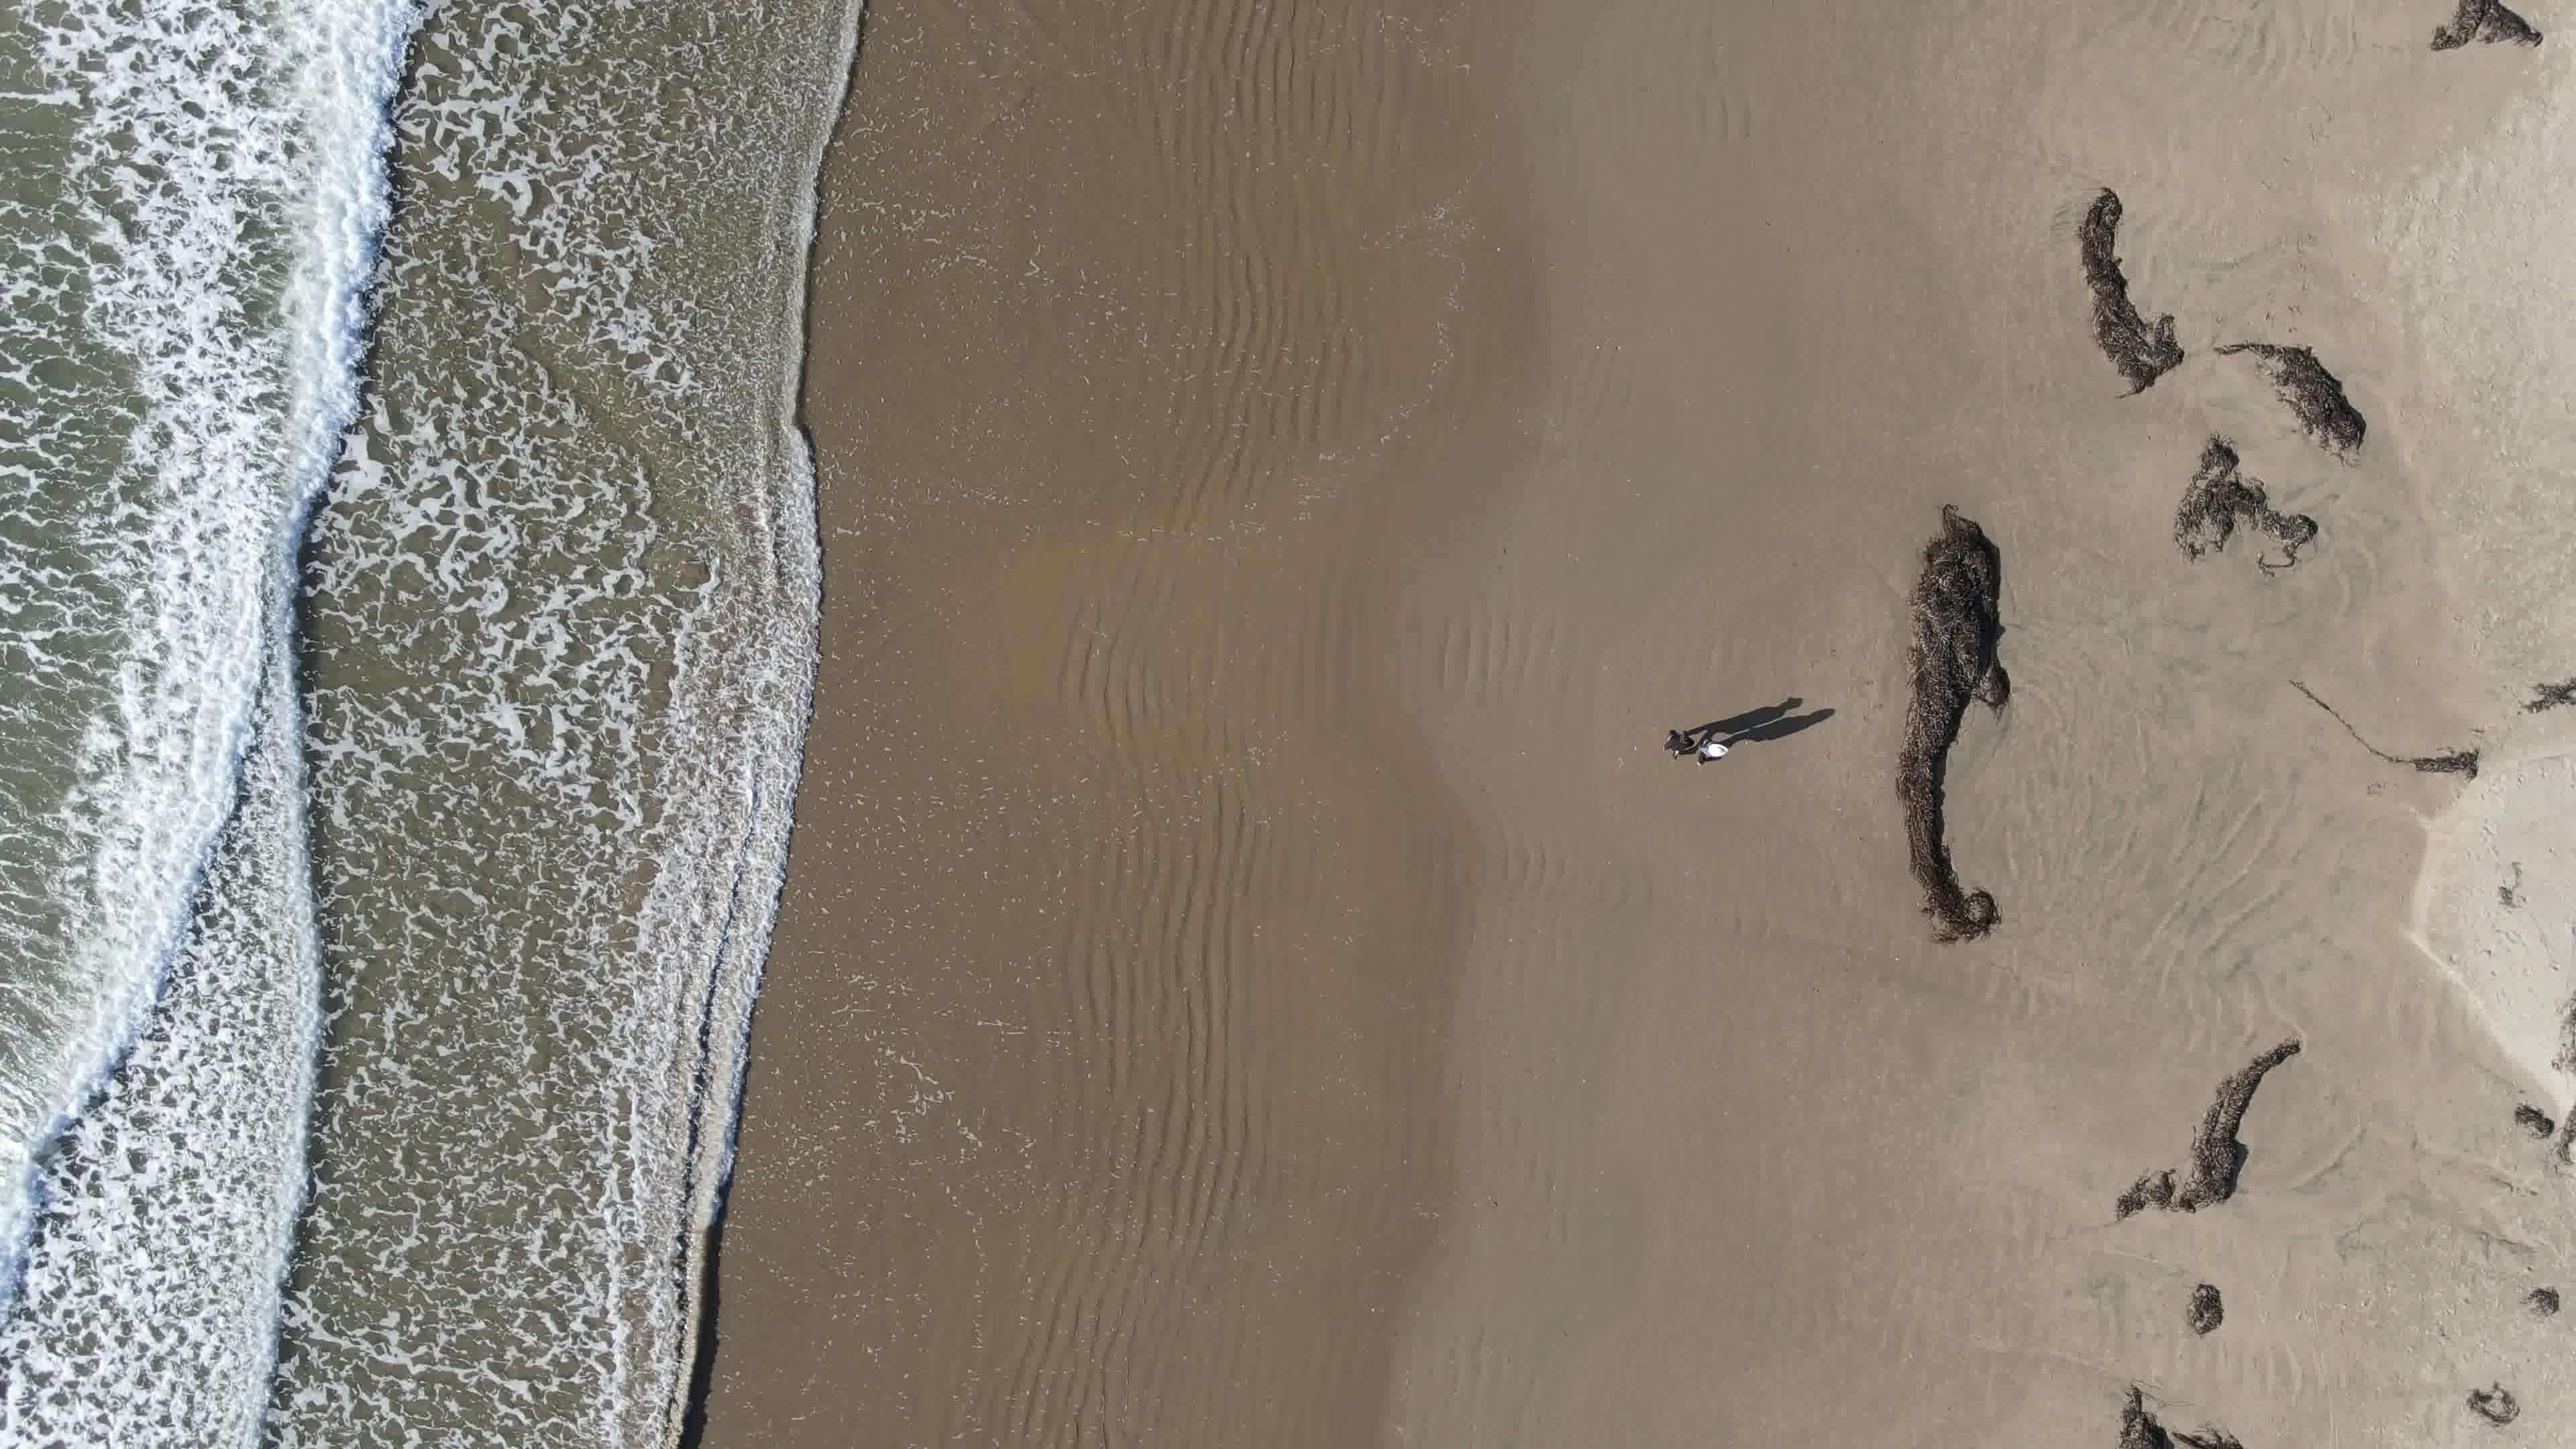

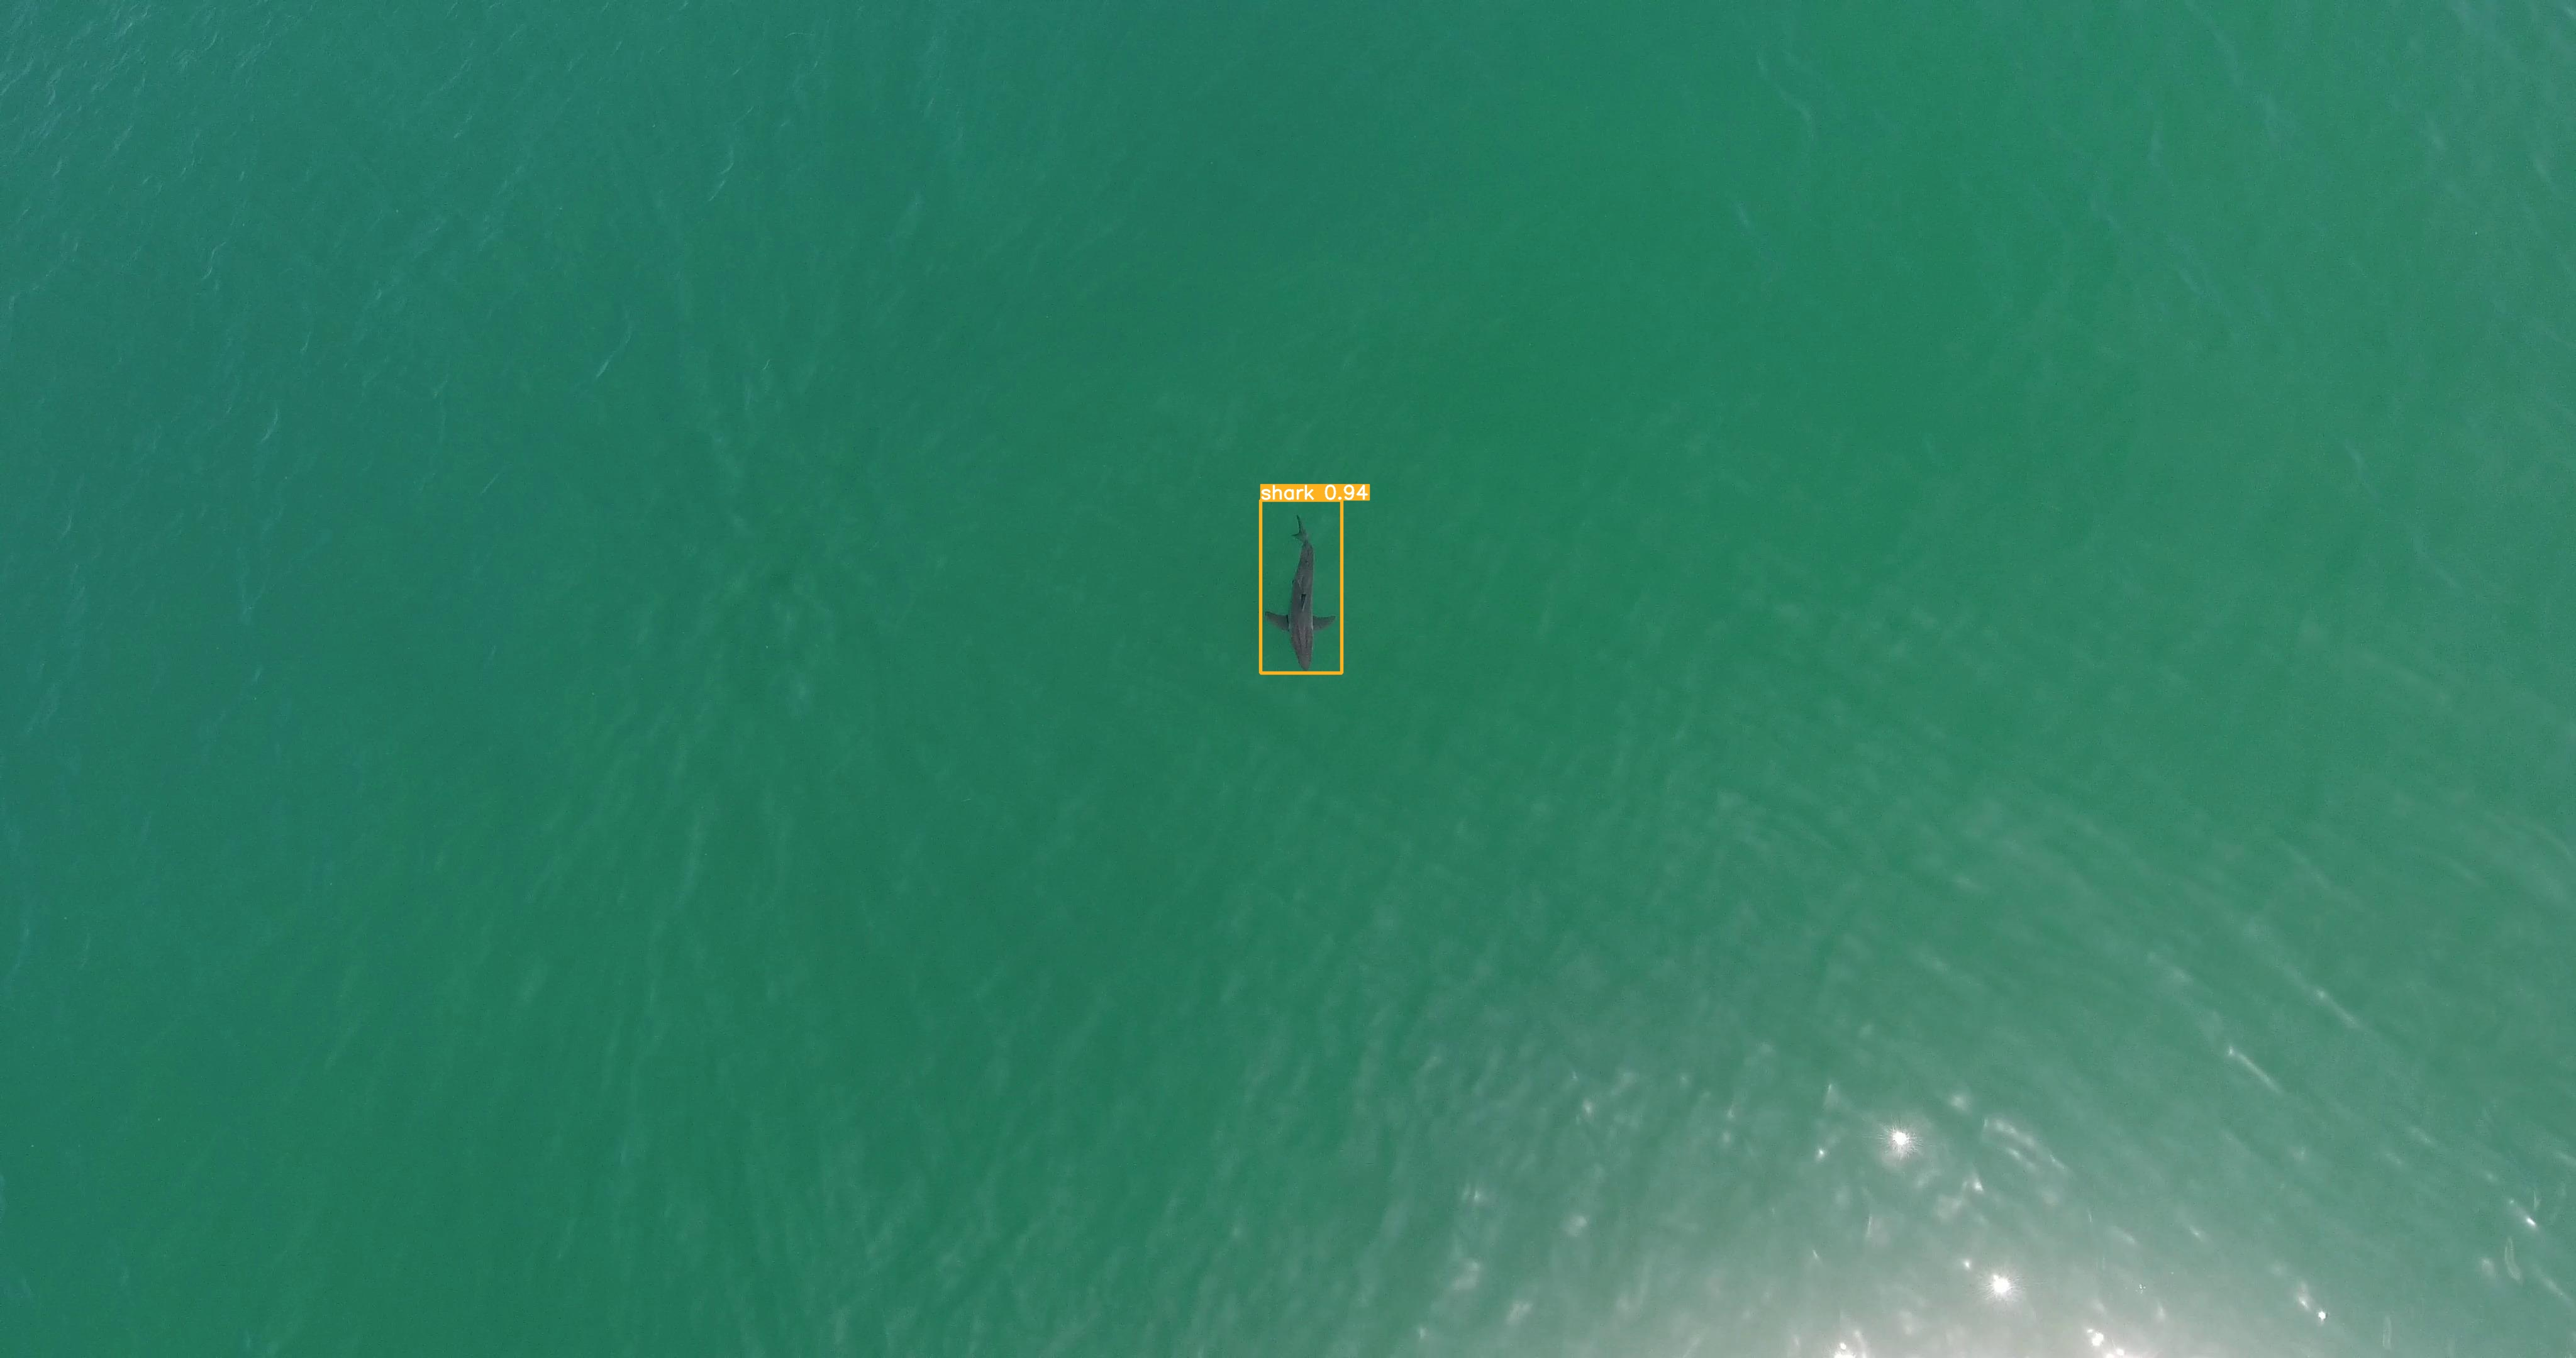

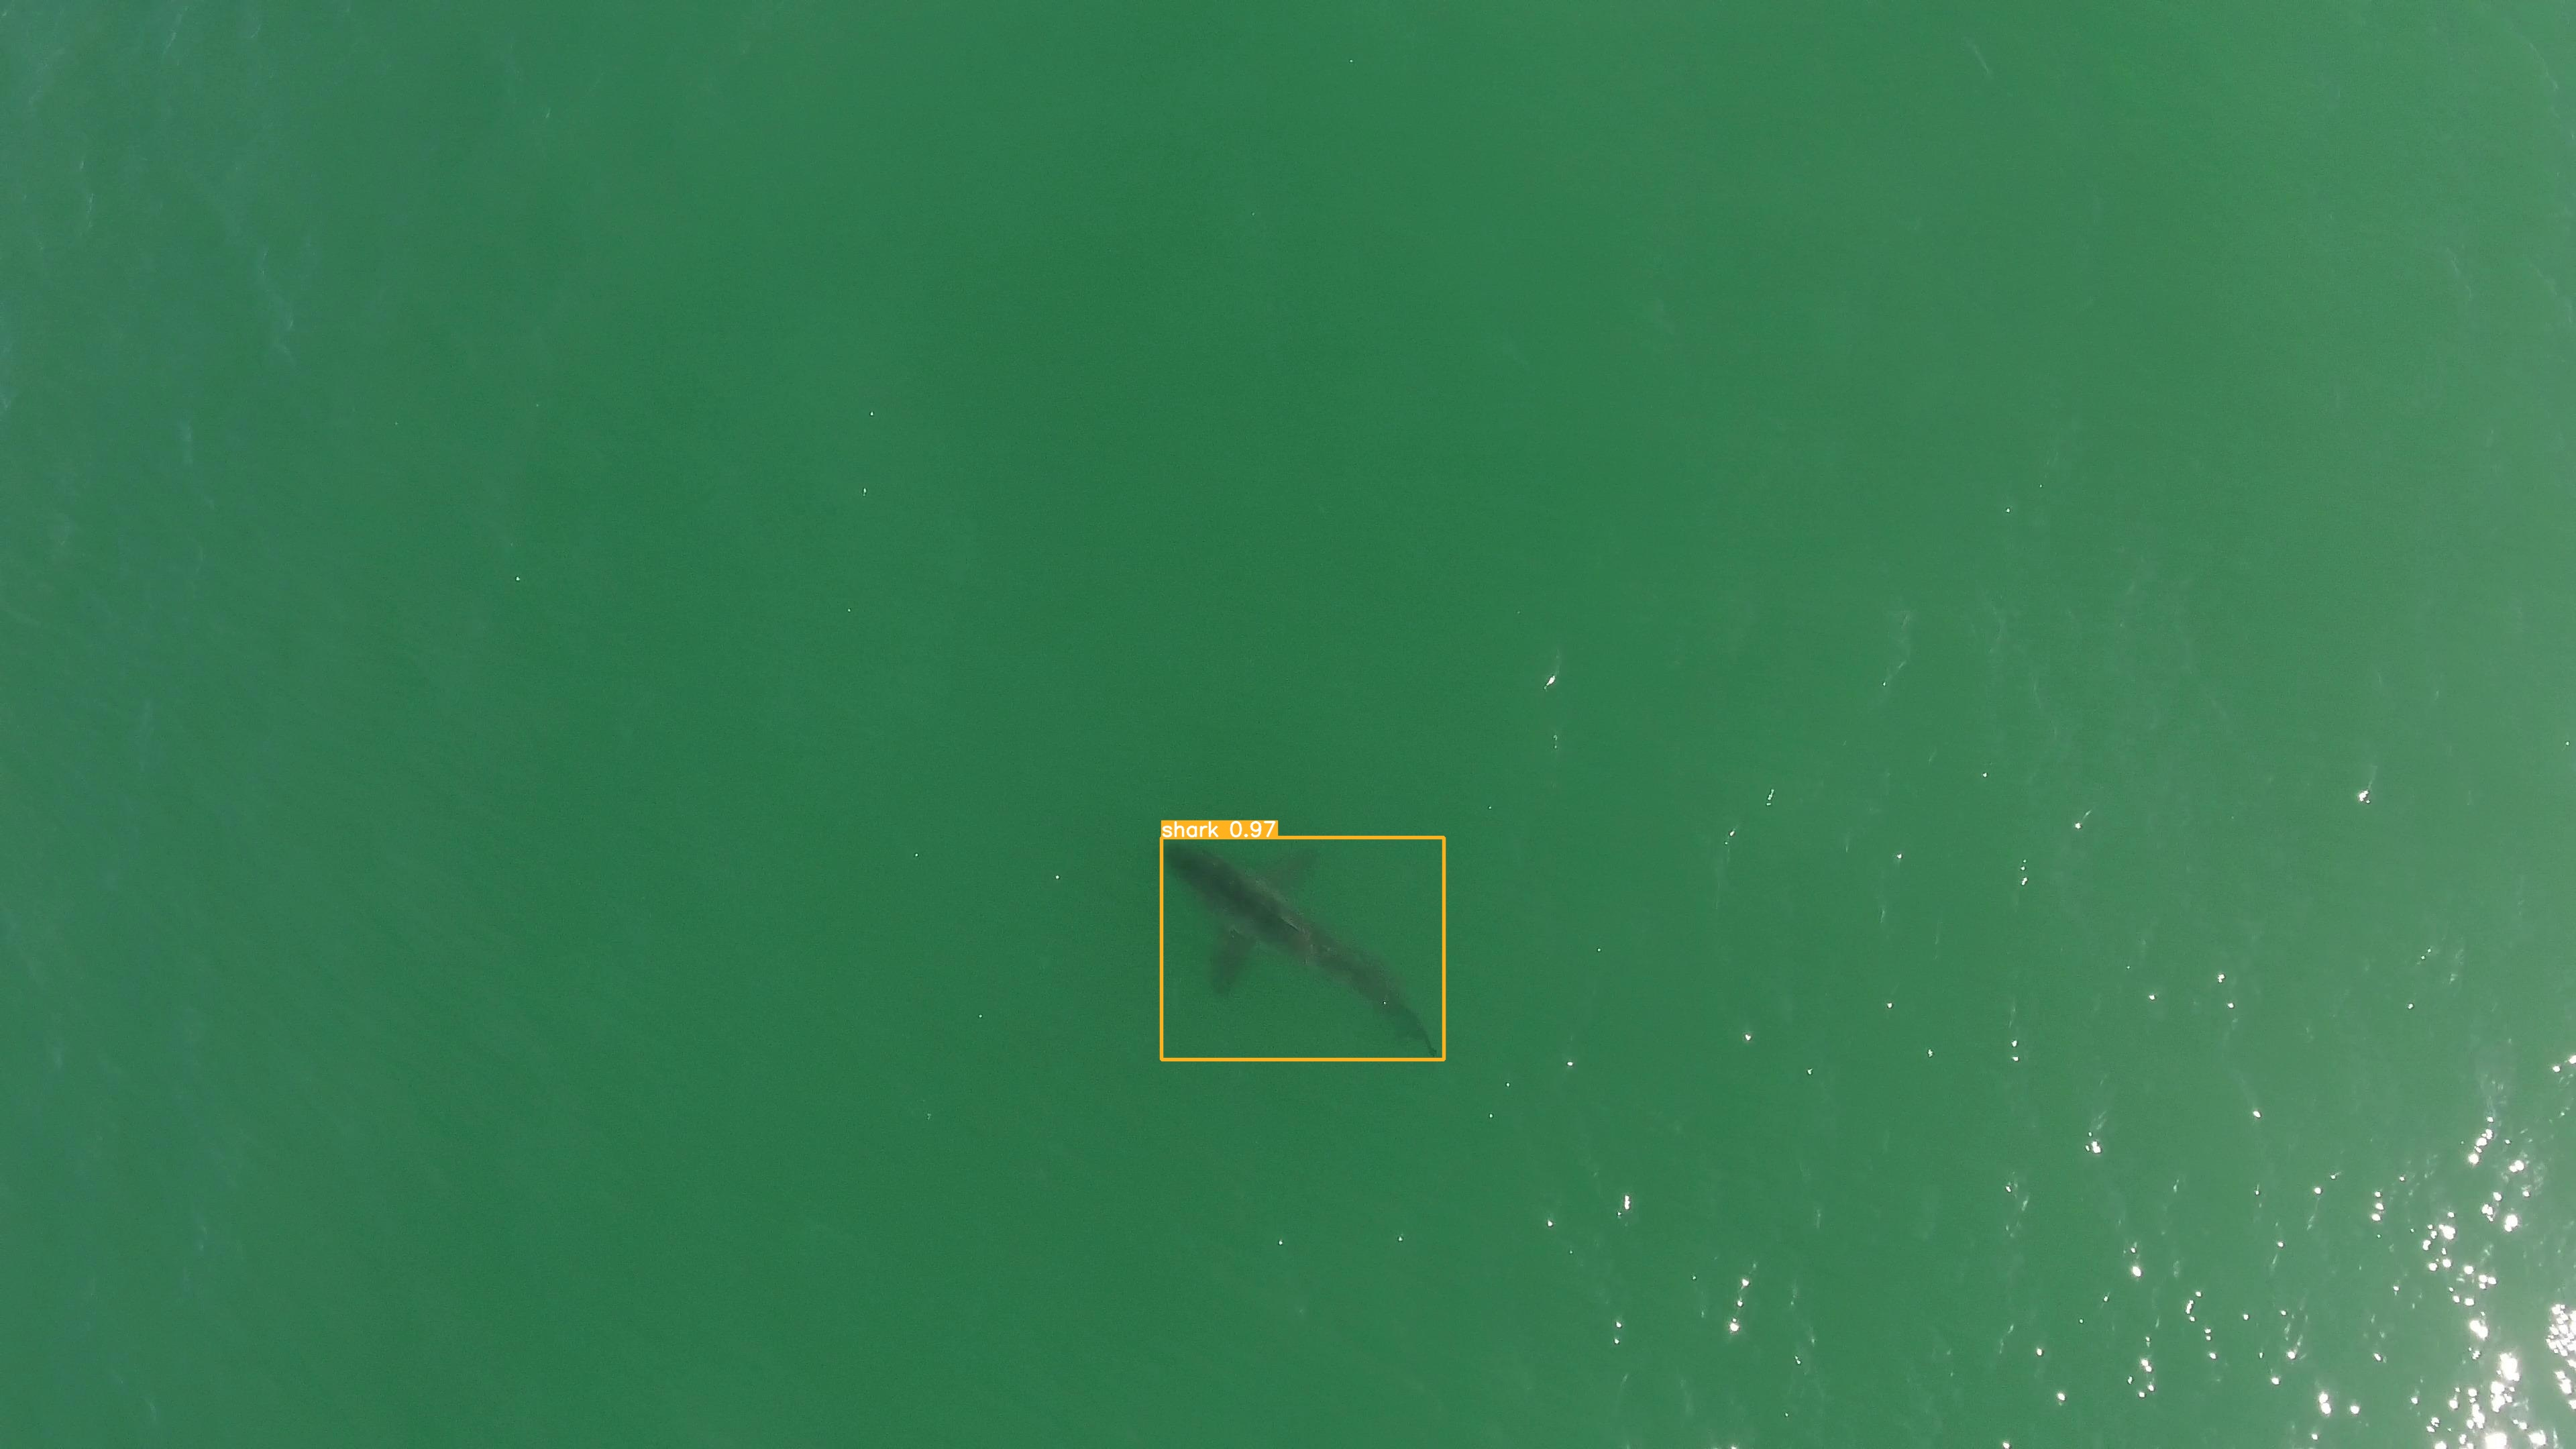

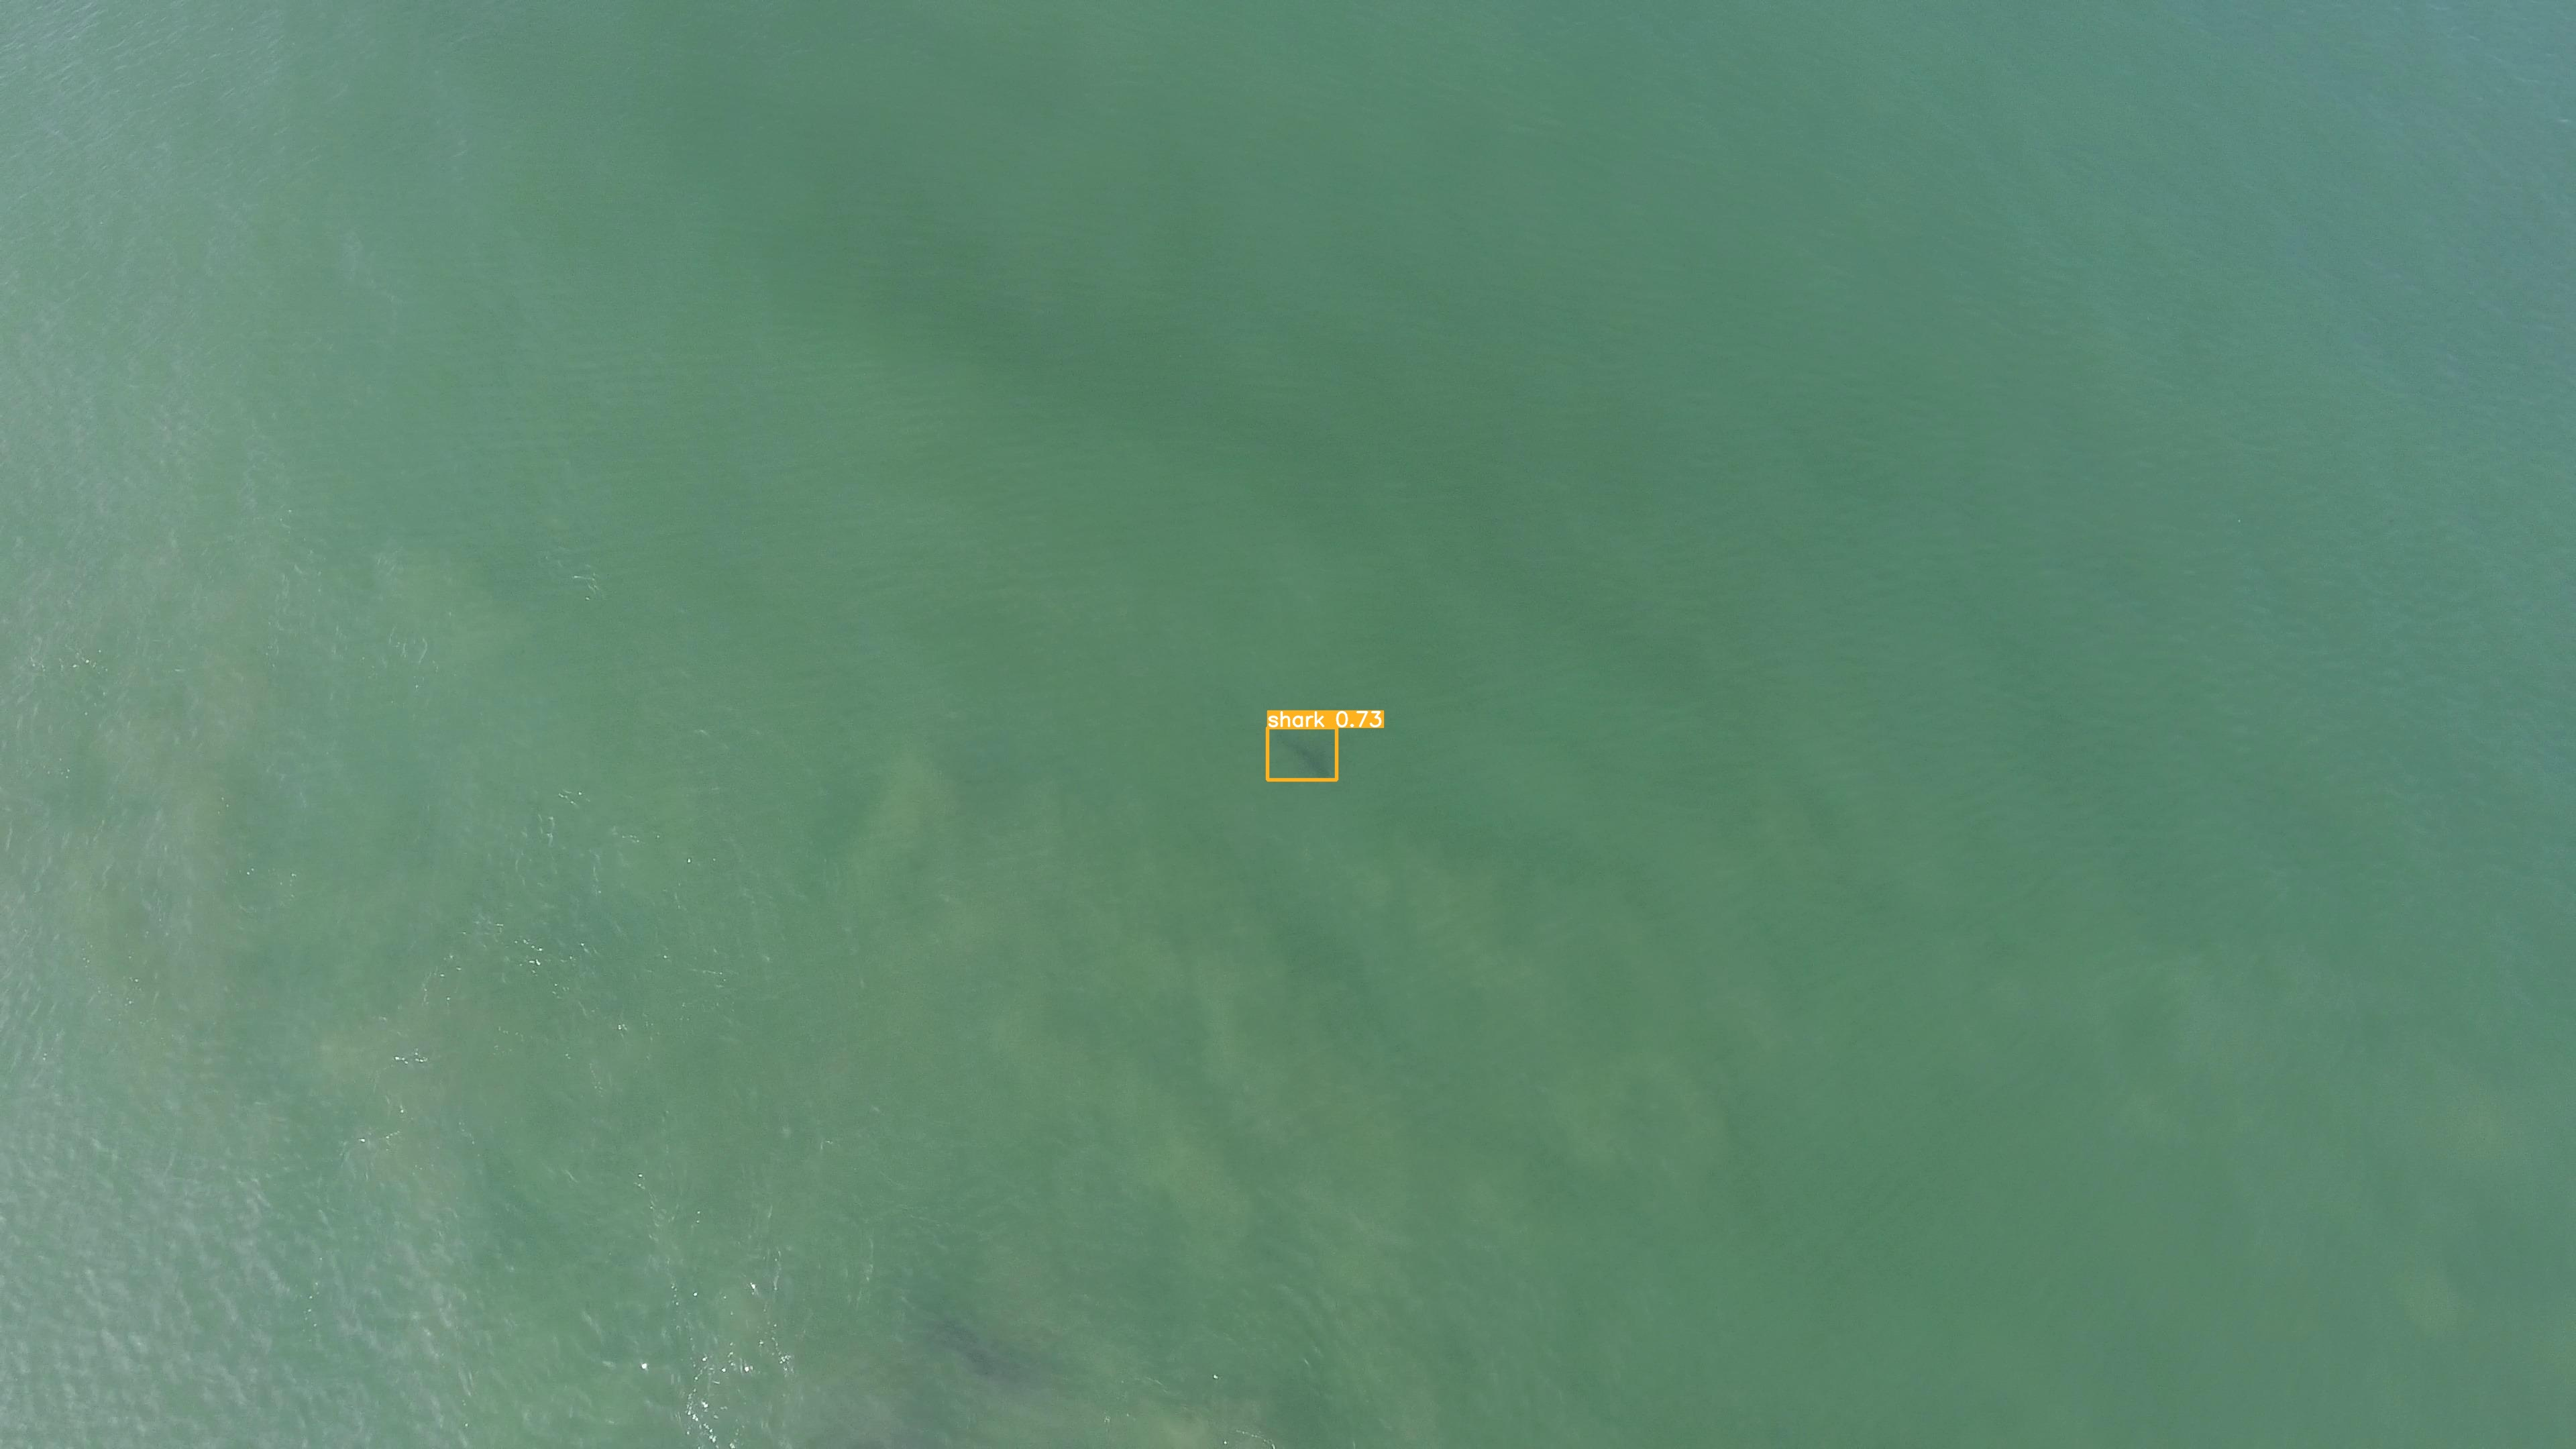

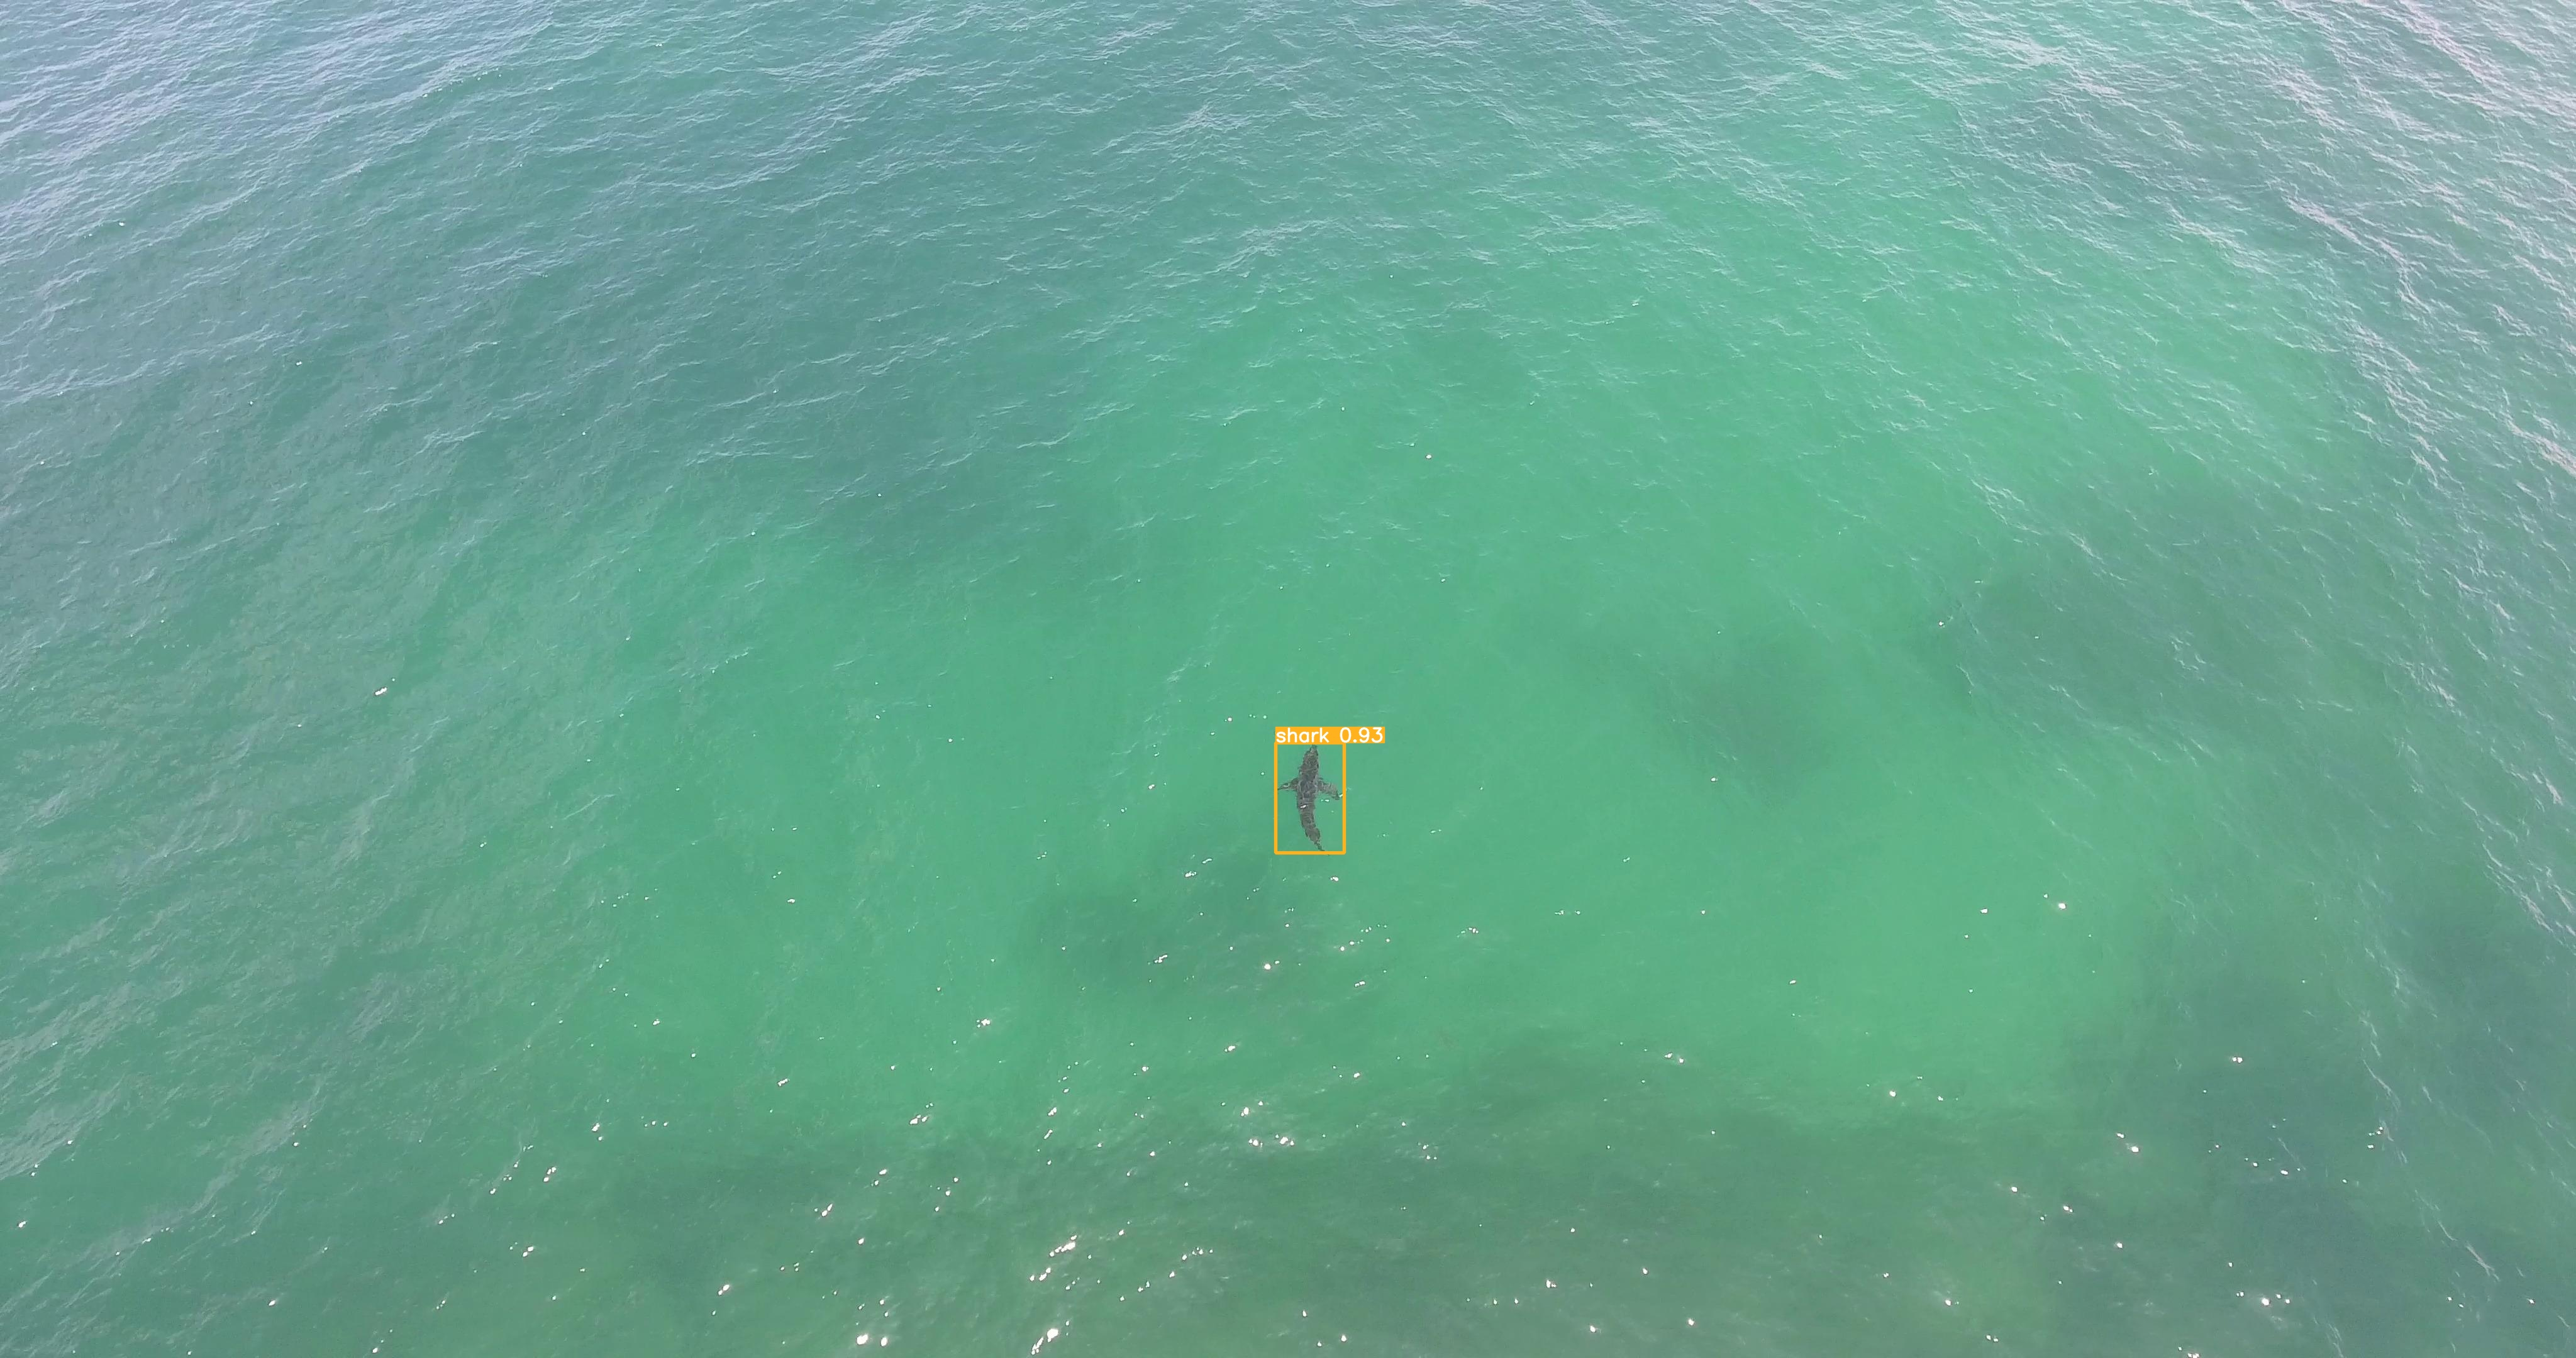

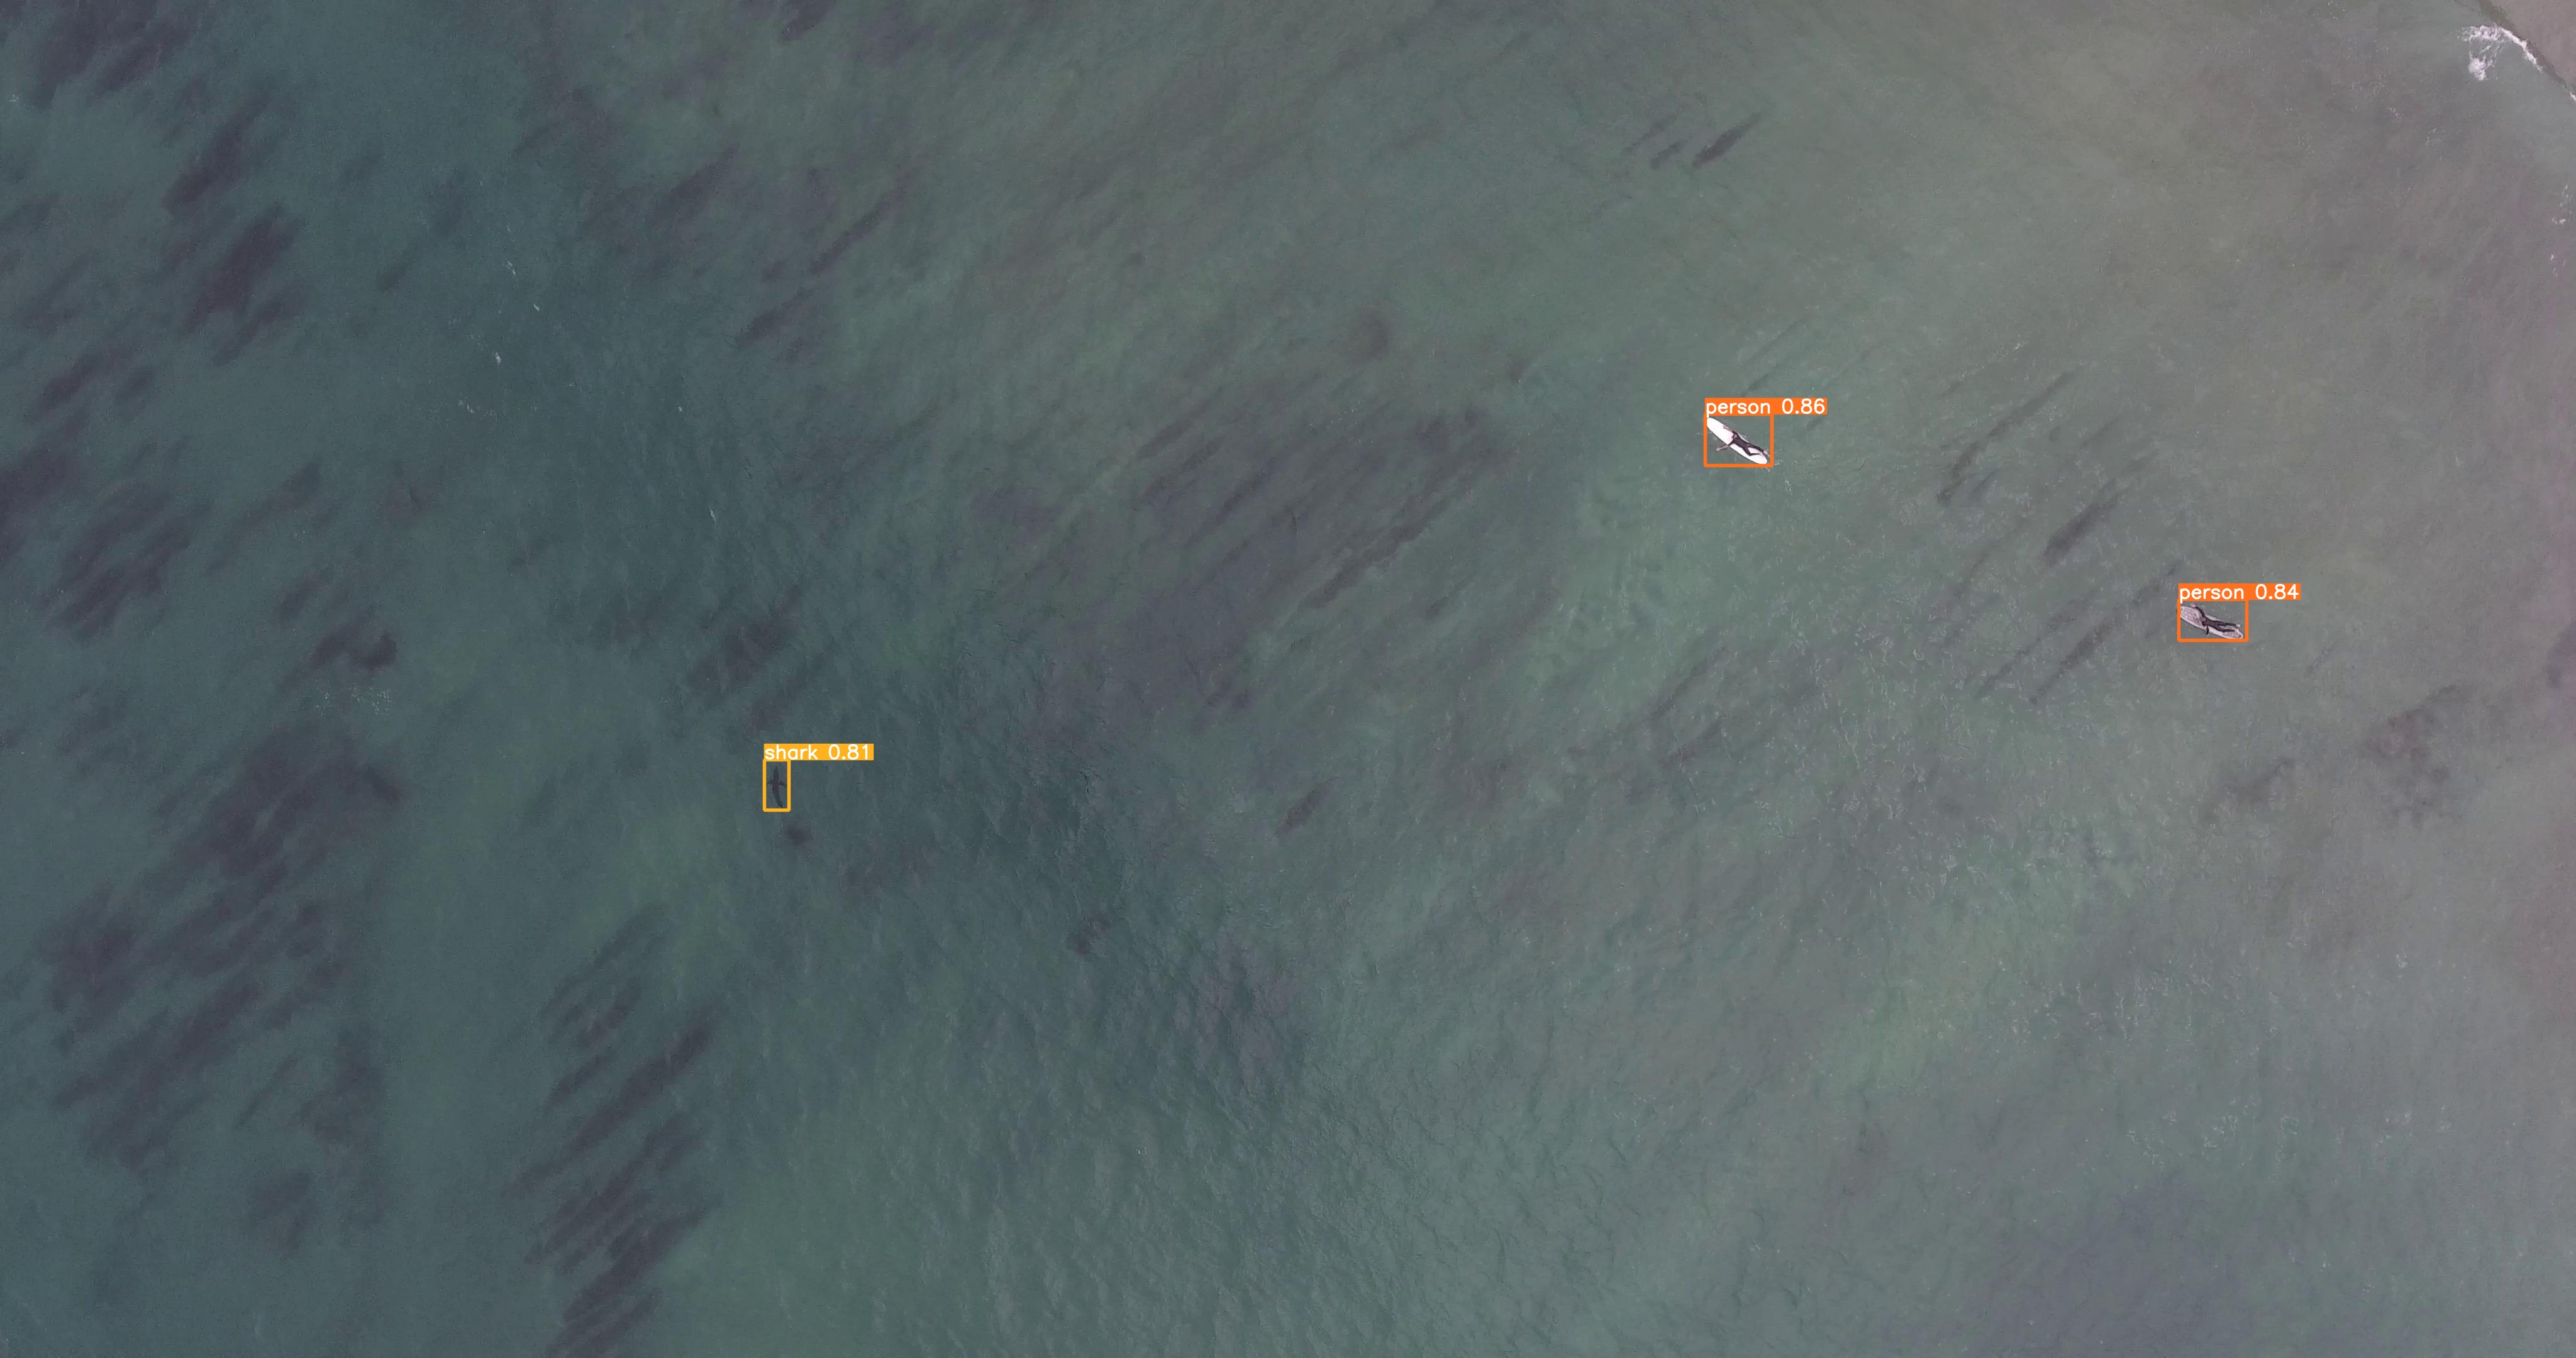

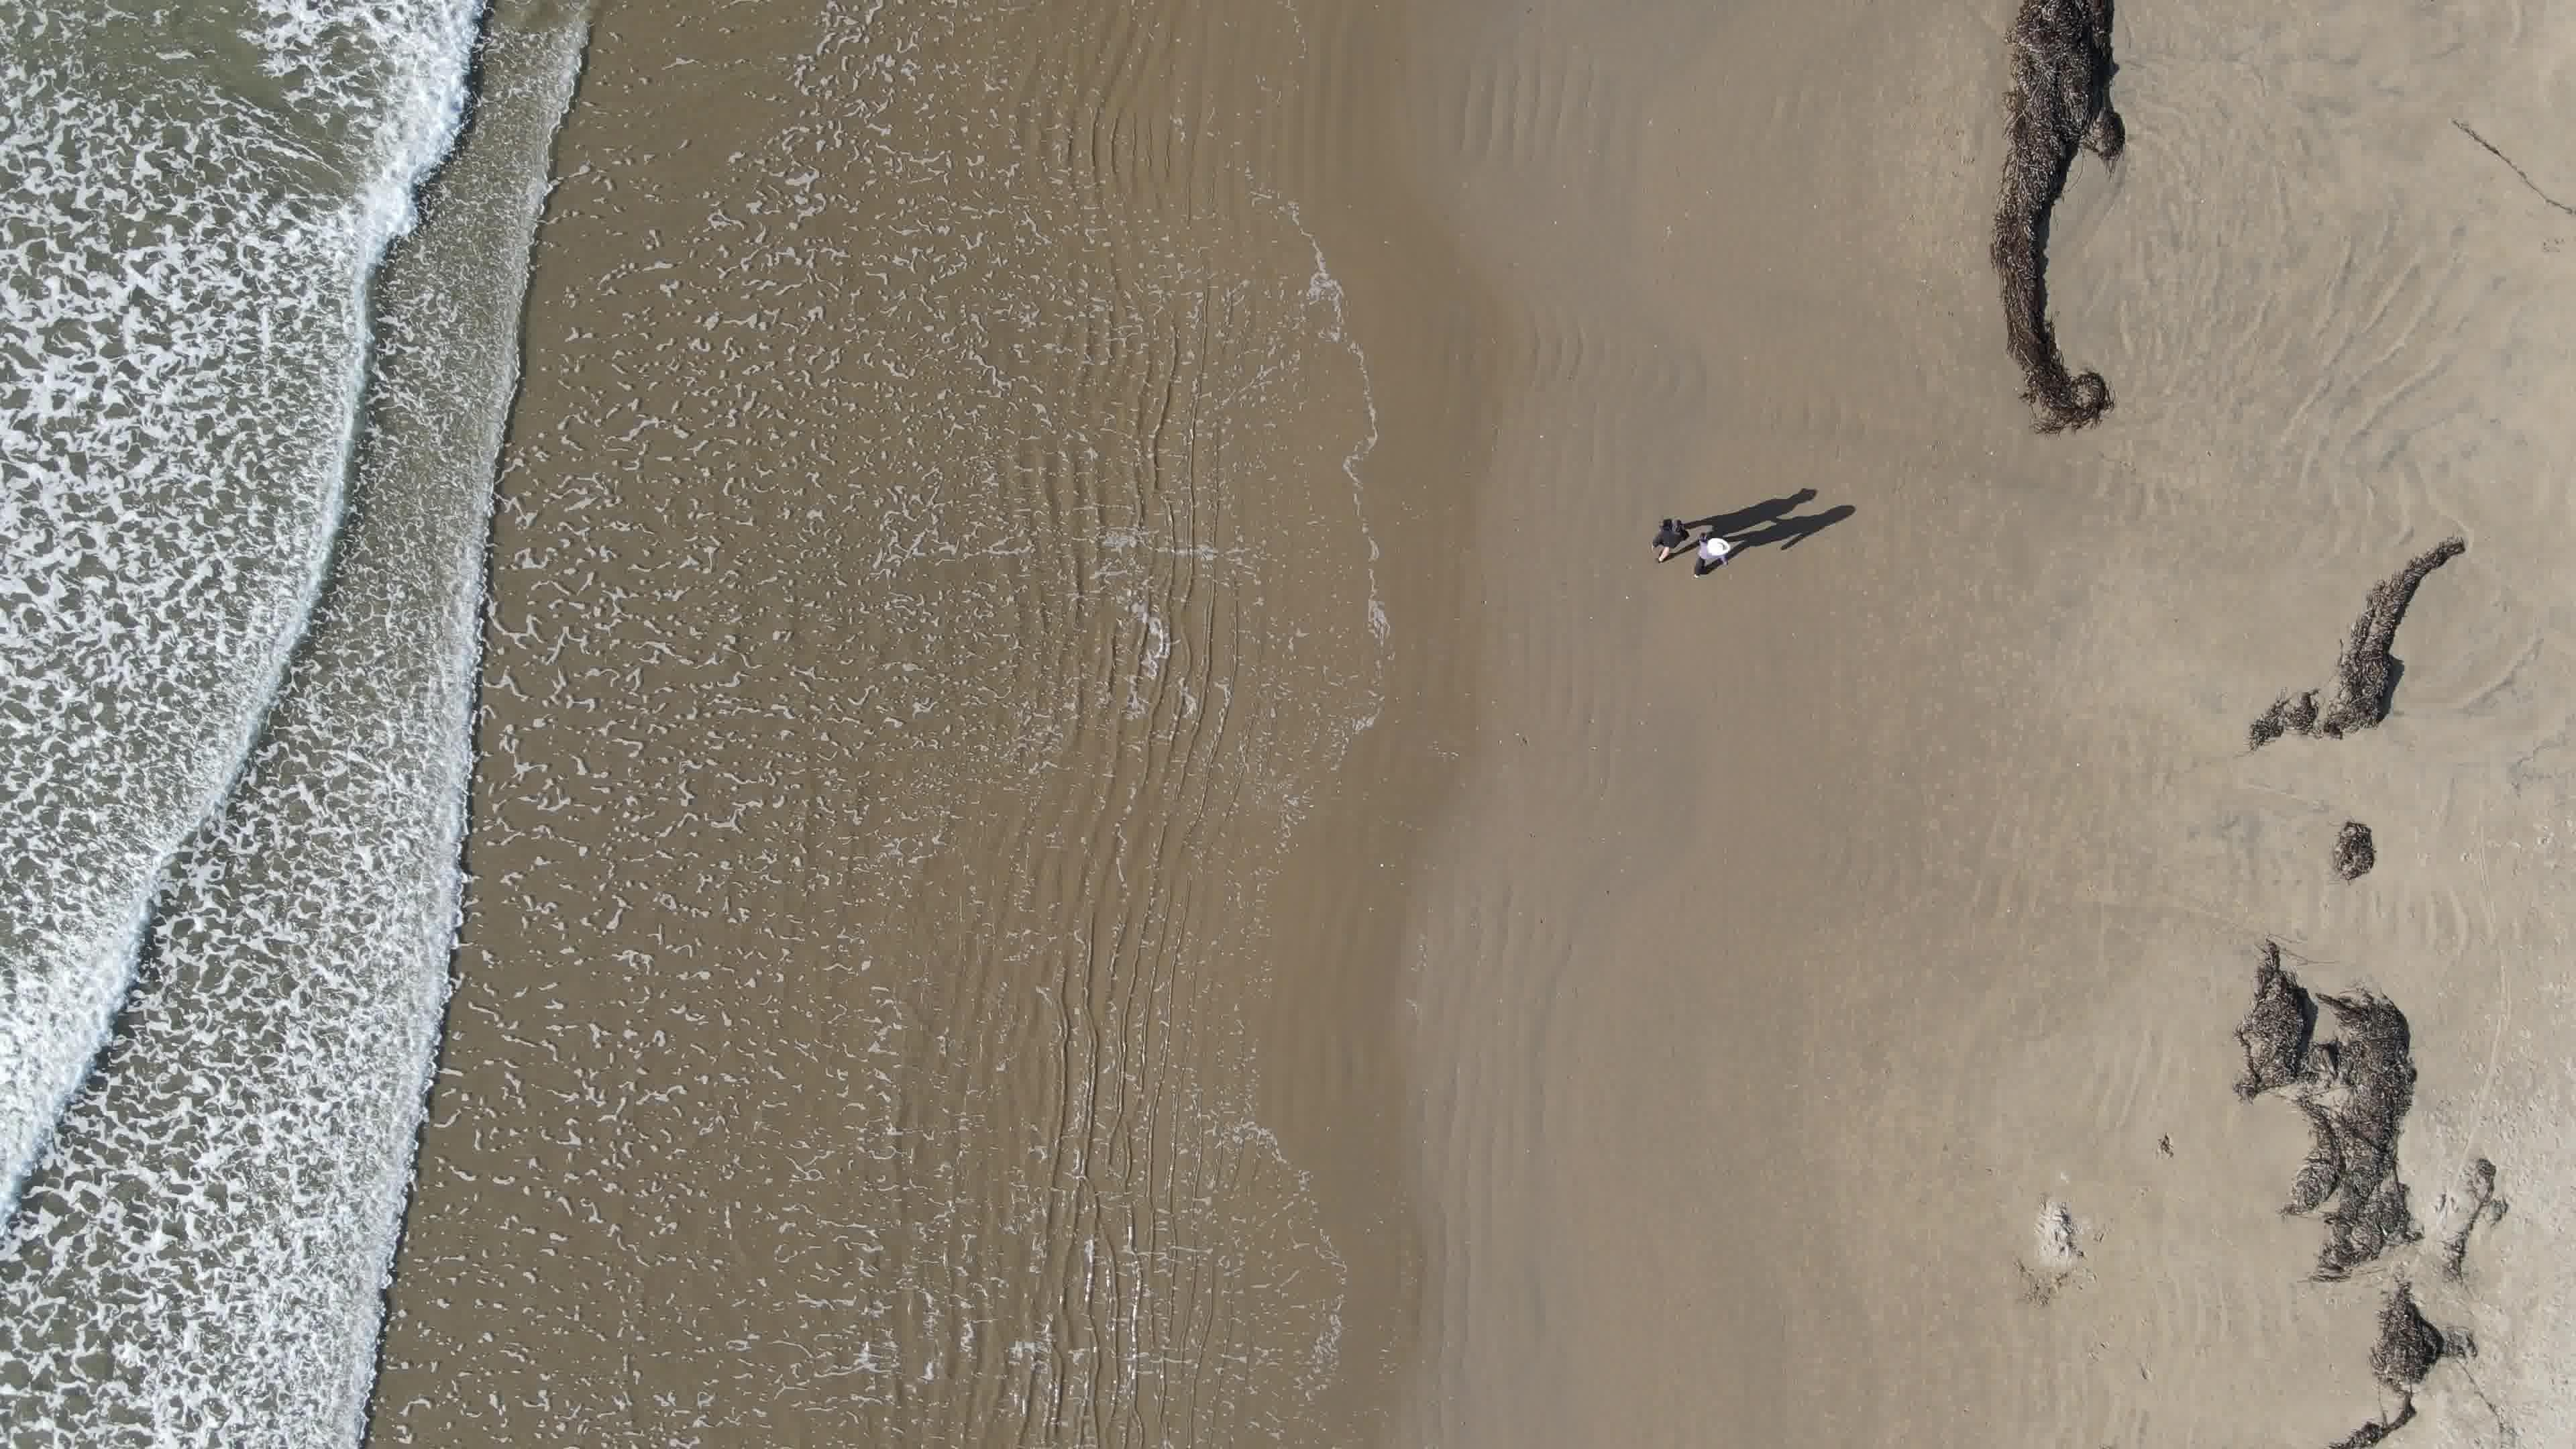

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [124]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [125]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive


In [126]:
%cp /content/yolov5/runs/train/yolov5s_results/ /content/gdrive/My\ Drive

cp: -r not specified; omitting directory '/content/yolov5/runs/train/yolov5s_results/'
